# IaC Pattern Mining — Checkpoint 1: Dataset Selection & EDA

**Course**: CSCE 676 — Data Mining and Analysis (Spring 2025)  
**Student**: Divyanshu Singh · Texas A&M University  
**Date**: February 12, 2025  
**GitHub**: [IaC Pattern Mining Repository](https://github.com/divyanshu-singh/iac-pattern-mining)

## Project Overview

Infrastructure as Code (IaC) has become the standard for provisioning and managing cloud resources, tools like **Terraform**, **Pulumi**, and **CloudFormation**(AWS) let engineers define entire cloud infrastructure in declarative configuration files. As organizations adopt IaC at scale, these codebases encode a rich record of real-world architectural decisions, security configurations, and provider preferences across AWS, GCP, and Azure.

This project applies data mining techniques to IaC datasets to answer questions like:

- **What infrastructure patterns recur** across providers and organizations?
- **How do IaC code structures differ** between Terraform, Pulumi, and other IaC languages?
- **What gaps exist** in current IaC datasets for LLM training purposes?
- **Can we detect anomalous or insecure configurations** through unsupervised methods?
- **How do infrastructure patterns cluster by domain** (web apps vs. data pipelines vs. ML systems)?

## Section A — Identification of Candidate Datasets

Below are three candidate datasets. All three focus on Infrastructure as Code but vary in scale, structure, and the kinds of analysis they support.

### Dataset 1: AutoIaC Evaluation Dataset (`iac-eval`)

| Property | Details |
|---|---|
| **Source** | [Hugging Face — autoiac-project/iac-eval](https://huggingface.co/datasets/autoiac-project/iac-eval) |
| **Paper** | Kon et al., *IaC-Eval: A Code Generation Benchmark for Cloud Infrastructure-as-Code Programs*, NeurIPS 2024 Datasets & Benchmarks |
| **Course topic alignment** | **Text Mining**: each record pairs a natural language prompt with reference Terraform HCL code and Rego intent specs, making it ideal for analyzing prompt structure, token distributions, and keyword patterns across cloud services.  **Frequent Pattern Mining**: the 458 scenarios span 30+ AWS services; resource co-occurrence within configurations forms natural itemsets (e.g., VPC + subnet + security group always appear together). **Clustering** scenarios have explicit difficulty levels (1–6, based on LOC, resource count, and interconnections) and service labels, providing rich features for grouping tasks by complexity or architectural style. |
| **Beyond-course techniques** | **Code Embeddings** — transformer-based models (CodeBERT, StarCoder) can embed both the NL prompts and the HCL reference solutions, enabling semantic similarity analysis across tasks and services. **Graph Neural Networks** — each Terraform configuration defines a dependency graph among resources (connected via attributes like `subnet_id`, `role_arn`); GNNs can learn structural embeddings of these graphs to identify recurring architectural motifs. |
| **Size & structure** | 458 human-curated scenarios compiled over 1,720+ person-hours. Each row contains: NL prompt, Rego intent specification (avg. 37.5 LOC), reference HCL configuration, and difficulty level. Configurations range from <10 LOC / 1 resource (level 1) to 280+ LOC / 24 resources / 33 interconnections (level 6). |
| **Data types** | Natural-language task descriptions (string), reference Terraform/HCL code (string), Rego intent specifications (string), AWS service labels (categorical), difficulty level (ordinal 1–6), resource types (categorical) |

### Dataset 2: The PIPr Dataset — Public Infrastructure as Code Programs (Zenodo)

| Property | Details |
|---|---|
| **Source** | [Zenodo — Record 10173400](https://zenodo.org/records/10173400) |
| **Paper** | Sokolowski, Spielmann & Salvaneschi, *The PIPr Dataset of Public Infrastructure as Code Programs*, MSR 2024 |
| **Course topic alignment** | **Frequent Pattern Mining**: with 37,712 real-world IaC programs, the resource types within each program form natural transaction baskets; this is the strongest dataset of the three for discovering common resource combinations at scale (e.g., how often does an S3 bucket co-occur with a CloudFront distribution?). **Anomaly Detection**: unlike the other two curated/synthetic datasets, PIPr contains real code with real bugs, deprecated APIs, missing tests, and potentially insecure configurations, making it the most meaningful candidate for anomaly detection. **Clustering**: programs can be clustered by IaC solution (Pulumi vs. AWS CDK vs. CDKTF), programming language (TypeScript 56%, Python 23%, Go, C#, Java), or architectural style. |
| **Beyond-course techniques** | **Graph Neural Networks**: each IaC program defines a resource dependency graph; with 15,504 redistributable programs, there is sufficient volume to train GNNs that learn structural embeddings of infrastructure architectures. **Topic Modeling**: LDA or BERTopic applied over resource declarations and configuration blocks can discover recurring infrastructure themes (e.g., "serverless API pattern", "data warehouse stack") across the corpus. |
| **Size & structure** | 37,712 IaC programs from 21,445 public GitHub repositories (snapshot: August 2022). 15,504 programs have licenses permitting redistribution (58 GB of source code). Metadata CSVs cover repositories, programs, and testing files. Programs span three PL-IaC solutions: AWS CDK (23,940), Pulumi (12,945), CDKTF (827). |
| **Data types** | Raw IaC source files (TypeScript, Python, C#, Go, Java, YAML), repository metadata (URL, stars, forks, creation/push dates, license), program metadata (solution, language, runtime, directory path), testing file metadata (techniques, keywords) |

### Dataset 3: Multi-IaC-Eval

| Property | Details |
|---|---|
| **Source** | [Hugging Face — AmazonScience/Multi-IaC-Eval](https://huggingface.co/datasets/AmazonScience/Multi-IaC-Eval) |
| **Paper** | Davidson et al., *Multi-IaC-Eval: Benchmarking Cloud Infrastructure as Code Across Multiple Formats*, arXiv 2509.05303 |
| **Course topic alignment** | **Text Mining**: each triplet contains a natural-language user request ("utterance") alongside initial and mutated IaC templates, enabling analysis of how NL intent maps to code changes across formats. **Clustering**: triplets can be grouped by IaC format (CloudFormation, Terraform, CDK), mutation type (add resource, modify property, change security setting), or resource category (top resources: IAM roles, EC2 subnets, S3 buckets). |
| **Beyond-course techniques** | **Code Embeddings**: transformer-based models can embed both the NL utterances and the IaC templates to measure alignment between user intent and generated code; the triplet structure (initial, utterance, expected) naturally supports contrastive learning setups. **Cross-format Transfer Analysis**: the same infrastructure changes are expressed in CFN, Terraform, and CDK, enabling direct comparison of how different IaC languages encode identical intent. |
| **Size & structure** | ~699 triplets total: 337 CloudFormation, 171 Terraform, 191 CDK (96 Python + 95 TypeScript). Each triplet contains an initial IaC template, a synthetic NL user request, and the expected mutated template. All templates validated with Checkov + format-specific linters (CFNLint, TFLint). CDK data is deterministically converted from CloudFormation via `cdk migrate`. Source templates drawn from 3 GitHub repositories. |
| **Data types** | Initial IaC templates (string — YAML/HCL/Python/TypeScript), NL mutation requests (string), expected mutated templates (string), IaC format label (categorical: CFN/TF/CDK), resource types (categorical) |

## Section B — Comparative Analysis of Datasets

The table below compares the three candidate datasets across the five required dimensions: supported data mining tasks, data quality issues, algorithmic feasibility, bias considerations, and ethical considerations. 

| Dimension | **IaC-Eval** | **PIPr** | **Multi-IaC-Eval** |
|---|---|---|---|
| **Supported tasks** | Text mining on prompt–code pairs; frequent pattern mining on resource co-occurrences; clustering by service/difficulty; code embeddings; GNNs on dependency graphs | Frequent pattern mining at scale (37K programs); anomaly detection on real-world configs; clustering by solution/language; GNNs on dependency graphs; topic modeling | Text mining on NL utterance–code triplets; clustering by format/mutation type; code embeddings with contrastive learning; cross-format transfer analysis |
| **Data quality issues** | High quality (human-curated, 1720+ hrs) but small (458 rows); AWS-only; Terraform-only; subjective difficulty heuristic | Large but noisy — no correctness guarantees; 67% of repos unlicensed; only 25% of programs have tests; snapshot from Aug 2022 may miss recent trends | Clean (Checkov + linter validated) but synthetic — NL utterances generated by Amazon Nova Pro; CDK data converted from CFN, not native; small (~700 triplets) |
| **Algorithmic feasibility** | All algorithms trivial at 458 rows; dependency graph extraction requires Terraform provider plugins but no cloud credentials | Largest dataset (58 GB source code); feasible on single machine but requires parsers for multiple languages (TS, Python, Go, C#, Java); GNN training on ~15K graphs feasible on single GPU | All algorithms trivial at ~700 triplets; triplet structure naturally supports edit distance and diff-based analysis |
| **Bias considerations** | AWS-only provider coverage; curation bias toward common services (VPC/IAM dominate); subjective difficulty calibration | Survivorship bias (public GitHub only, no enterprise IaC); popularity bias from API filtering; TypeScript dominance (56%); temporal bias (Aug 2022 snapshot) | Synthetic generation bias from Nova Pro's tendencies; source templates from only 3 GitHub repos; CDK converted from CFN misses native CDK patterns; AWS-only |
| **Ethical considerations** | Low risk, compile-time evaluation only, CC BY 4.0 + MIT licensed| Low risk, public code, no privacy concerns; ODC-By v1.0 licensed | Low risk all templates pass Checkov security scans |

## Section C — Dataset Selection

**Selected dataset: PIPr (The PIPr Dataset of Public Infrastructure as Code Programs)**

**Why PIPr for the course project:**

37K real IaC programs provide the scale that the other datasets lack (458 and ~700 records respectively). Resource types within each program form natural itemsets for **frequent pattern mining**. Real-world code with real bugs and insecure configs makes **anomaly detection** meaningful — unlike the curated/synthetic alternatives. Programs spanning three IaC solutions, seven languages, and thousands of architectural styles give **clustering** and **topic modeling** genuine structure to discover. And 15K+ resource dependency graphs provide sufficient volume for **GNN** training.

**For the larger fine-tuning goal**

PIPr's 15,504 redistributable programs can be parsed into (architecture intent → code) training pairs, with synthetic NL descriptions generated to augment the data. The multi-language coverage (TypeScript, Python, Go, C#, Java) means training data spans multiple IaC surface languages, not just Terraform HCL.

**Trade-offs:**

No built-in NL prompts (must be extracted or generated), multi-language parsing overhead, August 2022 snapshot age, and no correctness labels (quality filtering required).



## Section D — Exploratory Data Analysis (PIPr Dataset)

The PIPr dataset contains three metadata CSV files (`repositories.csv`, `programs.csv`, `testing-files.csv`) plus 58 GB of redistributable source code. This EDA explores the metadata to understand the dataset's structure, distributions, and quality.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load data ---
# Update these paths to wherever you extracted the PIPr metadata CSVs
# path relative to the virtual environment root
programs = pd.read_csv('../iac-pattern-mining/data/metadata/programs.csv')
repos = pd.read_csv('../iac-pattern-mining/data/metadata/repositories.csv')
testing = pd.read_csv('../iac-pattern-mining/data/metadata/testing-files.csv')

print(f'Programs:  {programs.shape[0]:,} rows, {programs.shape[1]} columns')
print(f'Repos:     {repos.shape[0]:,} rows, {repos.shape[1]} columns')
print(f'Testing:   {testing.shape[0]:,} rows, {testing.shape[1]} columns')
print()
print('--- Programs columns ---')
print(programs.dtypes)
print()
print('--- Repositories columns ---')
print(repos.dtypes)

Programs:  37,712 rows, 10 columns
Repos:     23,428 rows, 14 columns
Testing:   18,384 rows, 5 columns

--- Programs columns ---
ID               str
repository     int64
directory        str
solution         str
language         str
name             str
description      str
runtime          str
testing          str
tests            str
dtype: object

--- Repositories columns ---
ID                   int64
url                    str
downloaded            bool
name                   str
description            str
licenses               str
redistributable     object
created                str
updated                str
pushed                 str
fork                  bool
forks              float64
archive             object
programs               str
dtype: object


In [4]:
# Basic missing value check
print('=== Missing values (programs) ===')
print(programs.isnull().sum())
print()
print('=== Missing values (repositories) ===')
print(repos.isnull().sum())
print()
# Sample rows
programs.head(3)

=== Missing values (programs) ===
ID                 0
repository         0
directory          0
solution           0
language           0
name           24771
description    24960
runtime            0
testing        28277
tests          28277
dtype: int64

=== Missing values (repositories) ===
ID                     0
url                    0
downloaded             0
name                   0
description        12580
licenses              87
redistributable       87
created                2
updated                2
pushed                 2
fork                   0
forks                  2
archive                2
programs            1983
dtype: int64



,ID,repository,directory,solution,language,name,description,runtime,testing,tests
0,268440230/cdk/cdk.json,268440230,268440230/cdk,AWS CDK,python,NaN,NaN,python3 app.py,NaN,NaN
1,424290295/cdk.json,424290295,424290295,AWS CDK,typescript,NaN,NaN,npx ts-node --prefer-ts-exts bin/mad-shared-ac...,['awscdk'],['424290295/test/mad-shared-accounts-with-cdk....
2,464359643/cdk.json,464359643,464359643,AWS CDK,typescript,NaN,NaN,npx ts-node --prefer-ts-exts bin/aws-codepipel...,"['awscdk', 'awscdk_assert']",['464359643/test/aws-codepipeline-cdk.test.ts']


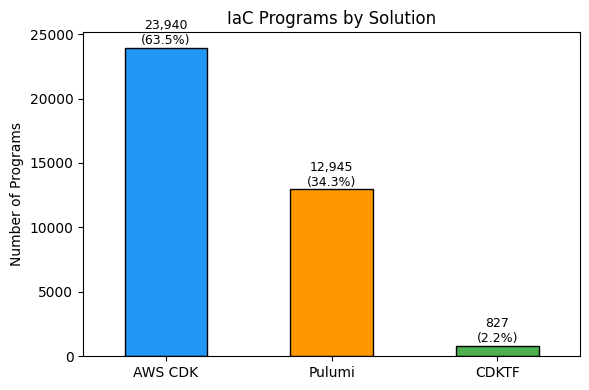

In [5]:
solution_counts = programs['solution'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))
solution_counts.plot(kind='bar', ax=ax, color=['#2196F3', '#FF9800', '#4CAF50'], edgecolor='black')
ax.set_title('IaC Programs by Solution')
ax.set_ylabel('Number of Programs')
ax.set_xlabel('')
for i, v in enumerate(solution_counts):
    ax.text(i, v + 300, f'{v:,}\n({v/len(programs)*100:.1f}%)', ha='center', fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

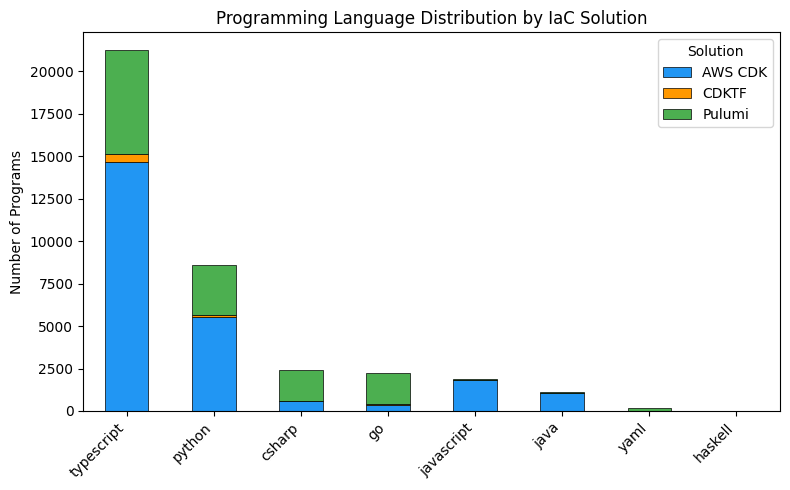

In [6]:
# Language distribution plot, broken down by solution
lang_solution = programs.groupby(['language', 'solution']).size().unstack(fill_value=0)
lang_solution = lang_solution.loc[lang_solution.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(8, 5))
lang_solution.plot(kind='bar', stacked=True, ax=ax, 
                   color=['#2196F3', '#FF9800', '#4CAF50'], edgecolor='black', linewidth=0.5)
ax.set_title('Programming Language Distribution by IaC Solution')
ax.set_ylabel('Number of Programs')
ax.set_xlabel('')
ax.legend(title='Solution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

          tested  total  pct_tested
solution                           
AWS CDK     9152  23940        38.2
CDKTF        121    827        14.6
Pulumi       162  12945         1.3


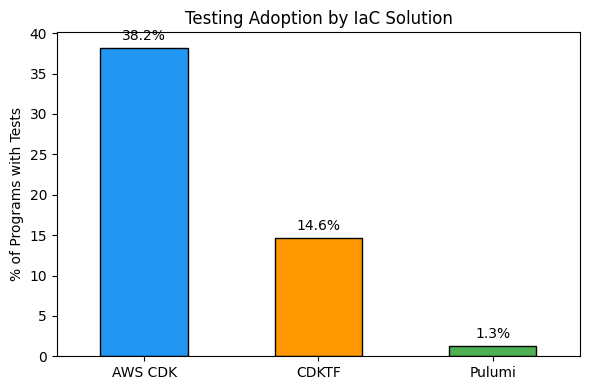

In [7]:
# Testing adoption by solution
# The 'testing' column contains a list of testing techniques; empty means no tests
programs['has_tests'] = programs['testing'].notna() & (programs['testing'] != '[]')

test_by_solution = programs.groupby('solution')['has_tests'].agg(['sum', 'count'])
test_by_solution['pct'] = (test_by_solution['sum'] / test_by_solution['count'] * 100).round(1)
test_by_solution.columns = ['tested', 'total', 'pct_tested']
print(test_by_solution)

fig, ax = plt.subplots(figsize=(6, 4))
test_by_solution['pct_tested'].plot(kind='bar', ax=ax, color=['#2196F3', '#FF9800', '#4CAF50'], edgecolor='black')
ax.set_title('Testing Adoption by IaC Solution')
ax.set_ylabel('% of Programs with Tests')
ax.set_xlabel('')
for i, v in enumerate(test_by_solution['pct_tested']):
    ax.text(i, v + 1, f'{v}%', ha='center', fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

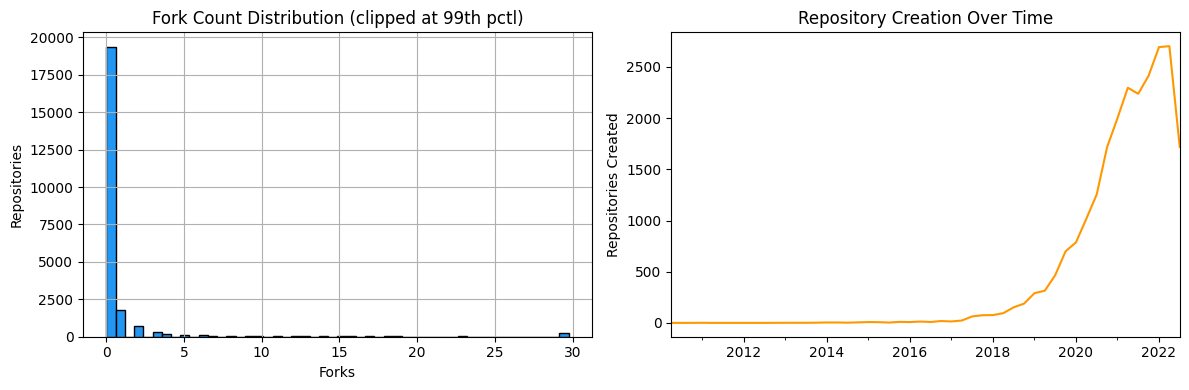

Median forks: 0.0
Mean forks:   3.2
Fork = 0:     19,363 repos (82.6%)


In [8]:
# Repository popularity distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Stars distribution (log scale due to heavy right skew)
repos['forks'].clip(upper=repos['forks'].quantile(0.99)).hist(bins=50, ax=axes[0], 
                                                                color='#2196F3', edgecolor='black')
axes[0].set_title('Fork Count Distribution (clipped at 99th pctl)')
axes[0].set_xlabel('Forks')
axes[0].set_ylabel('Repositories')

# Created date distribution
repos['created_dt'] = pd.to_datetime(repos['created'], errors='coerce')
repos['created_dt'].dt.to_period('Q').value_counts().sort_index().plot(ax=axes[1], 
                                                                        color='#FF9800')
axes[1].set_title('Repository Creation Over Time')
axes[1].set_xlabel('')
axes[1].set_ylabel('Repositories Created')

plt.tight_layout()
plt.show()

print(f'Median forks: {repos["forks"].median()}')
print(f'Mean forks:   {repos["forks"].mean():.1f}')
print(f'Fork = 0:     {(repos["forks"] == 0).sum():,} repos ({(repos["forks"] == 0).mean()*100:.1f}%)')

Programs per repo — median: 1.0, mean: 1.8, max: 3664
Single-program repos: 19,370 (90.3%)


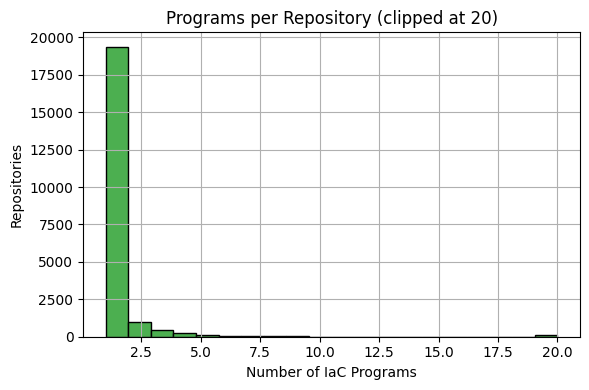

In [9]:
programs_per_repo = programs.groupby('repository').size()

print(f'Programs per repo — median: {programs_per_repo.median()}, '
      f'mean: {programs_per_repo.mean():.1f}, max: {programs_per_repo.max()}')
print(f'Single-program repos: {(programs_per_repo == 1).sum():,} '
      f'({(programs_per_repo == 1).mean()*100:.1f}%)')

fig, ax = plt.subplots(figsize=(6, 4))
programs_per_repo.clip(upper=20).hist(bins=20, ax=ax, color='#4CAF50', edgecolor='black')
ax.set_title('Programs per Repository (clipped at 20)')
ax.set_xlabel('Number of IaC Programs')
ax.set_ylabel('Repositories')
plt.tight_layout()
plt.show()

In [10]:
# Solution x Language cross-tabulation
cross = pd.crosstab(programs['solution'], programs['language'])
print('Solution × Language cross-tabulation:')
print(cross)
print()

# Sparsity: what fraction of solution-language combinations have >0 programs?
total_cells = cross.shape[0] * cross.shape[1]
nonzero_cells = (cross > 0).sum().sum()
print(f'Non-zero cells: {nonzero_cells}/{total_cells} ({nonzero_cells/total_cells*100:.0f}%)')
print(f'(Full resource co-occurrence sparsity will be computed after parsing source files)')

Solution × Language cross-tabulation:
language  csharp    go  haskell  java  javascript  python  typescript  yaml
solution                                                                   
AWS CDK      563   338        0  1035        1844    5521       14639     0
CDKTF         28    73        0    34           5     162         525     0
Pulumi      1835  1834        1    75          35    2927        6081   157

Non-zero cells: 20/24 (83%)
(Full resource co-occurrence sparsity will be computed after parsing source files)


# Section E - Initial Insights and Direction

Based on the Exploratory Data Analysis of the PIPr dataset, here are the initial observations, hypotheses, and potential research questions that will guide the project.

### Observation 1: Testing adoption is highly uneven across IaC tools.
The EDA reveals a stark contrast in testing culture: AWS CDK programs have a ~38% testing rate, while Pulumi programs sit at only ~1.3%.

**Hypothesis:** The presence of test files is a reliable proxy for "production-grade" quality. Patterns mined from the "tested" subset will reflect enterprise best practices, while the "untested" subset is likely dominated by toy projects, tutorials, or incomplete prototypes.

**Potential RQs:**
- Do structural patterns in "tested" infrastructure differ significantly from "untested" ones (i.e., can we fingerprints "production-readiness")?
- Can we use the tested subset as a "gold standard" to train anomaly detection models for the broader corpus?

## Observation 2: The dataset is heavily skewed towards AWS CDK and TypeScript.
Algorithmically, AWS CDK (23,940 programs) and TypeScript (dominate language) overshadow other combinations like Pulumi-Go or CDKTF-Python.

**Hypothesis:** Frequent pattern mining algorithms (like FP-Growth) will inherently bias towards AWS CDK conventions and TypeScript idioms unless the conceptual model is abstracted away from the textual syntax.

**Potential RQs:**
- How can we normalize Resource Dependency Graphs to identify architectural patterns that transcend specific IaC tools (e.g., identifying a "Serverless API" pattern regardless of whether it's written in CDK-TypeScript or Pulumi-Python)?
- Are security anomalies tool-specific (e.g., specific to how CDK synthesizes CloudFormation) or logic-specific (e.g., overly permissive IAM roles)?

## Observation 3: Natural language descriptions are largely missing (~66%).

**Hypothesis:** We cannot rely on text mining (descriptions/Readmes) for clustering domains (e.g., "ML Pipeline" vs "Web App"). We must rely on the structural topology of the resources themselves.

**Potential RQs:**
Can Graph Neural Networks (GNNs) effectively cluster infrastructure by "intent" (e.g., distinguishing a data warehouse form a web server) using only the resource types and their connections?
